In [8]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [9]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# do t-test
from scipy.stats import ttest_ind

from SSMuLA.fitness_process_vis import parse_lib_stat
from SSMuLA.de_simulations import DE_COLORS, DE_TYPES, DE_LEGEND_MAP
from SSMuLA.landscape_global import LIB_INFO_DICT
from SSMuLA.vis import PRESENTATION_PALETTE_SATURATE, LIB_COLORS
from SSMuLA.zs_analysis import (
    ZS_OPTS,
    ZS_COMB_OPTS,
    ZS_OPTS_LEGEND,
)
from SSMuLA.vis_summary import (
    ZS_OPTS_APPENDED,
    ZS_COLOR_MAP_APPENDED
)

%matplotlib inline

In [14]:
N_SAMPLE_LIST = [24, 48, 96, 192, 288, 384, 480, 576, 960, 1920]
TOTAL_N_LIST = [n + 96 for n in N_SAMPLE_LIST]

In [4]:
five_zs = {
    "none": PRESENTATION_PALETTE_SATURATE["gray"],
    "ed_score": PRESENTATION_PALETTE_SATURATE["orange"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "esmif_score": PRESENTATION_PALETTE_SATURATE["yellow"],
    "coves_score": PRESENTATION_PALETTE_SATURATE["brown"],
}

triad_colors = {
    "Triad-esm_score": PRESENTATION_PALETTE_SATURATE["purple"],
    "Triad-ev_score": PRESENTATION_PALETTE_SATURATE["green"],
    "Triad_score": PRESENTATION_PALETTE_SATURATE["blue"],
    "struc-comb_score": PRESENTATION_PALETTE_SATURATE["yellow"],
}


In [25]:
def aggregate_alde_df(
    eq_n: int,
    lib_list: list,
    zs: str = "",
    alde_model: str = "Boosting Ensemble",
    alde_encoding: str = "onehot",
    alde_acq: str = "GREEDY",
    alde_dir: str = "/disk2/fli/alde4ssmula",
) -> pd.DataFrame:

    """
    Aggregate ALDE results for a given list of libraries and equal n.

    Args:
    - eq_n (int): Equal n for the libraries.
    - lib_list (list): List of libraries to aggregate.

    Returns:
    - df (pd.DataFrame): Aggregated ALDE results.
    """

    df = pd.DataFrame(
        columns=[
            "n_sample",
            "top_maxes_mean",
            "top_maxes_std",
            "if_truemaxs_mean",
            "if_truemaxs_std",
        ]
    )

    for n in N_SAMPLE_LIST:

        if zs != "":
            zs_append = f"{zs}_"
            res_append = ""
        else:
            zs_append = ""
            res_append = "_2"

        if eq_n == 1:
            csv_path = f"{alde_dir}/results/{zs_append}all_{str(n)}+96/all_results{res_append}.csv"
            
        else:
            csv_path = f"{alde_dir}/results/{zs_append}{str(eq_n)}eq_{str(int((n+96)/eq_n))}/all_results{res_append}.csv"

        if os.path.exists(csv_path):
            a_df = pd.read_csv(csv_path)

            # Get the max Timestep for each Protein
            max_timesteps = a_df.groupby("Protein")["Timestep"].transform("max")
            # DNN Ensemble
            # Boosting Ensemble
            slice_df = a_df[
                (a_df["Encoding"] == alde_encoding)
                & (a_df["Acquisition"] == alde_acq)
                & (a_df["Model"] == alde_model)
                & (a_df["Protein"].isin(lib_list))
                & (a_df["Timestep"] == max_timesteps)
            ]
            # for each Protein take the max of the timestep

            # print(slice_df)
            df = df._append(
                {
                    "n_sample": n,
                    "top_maxes_mean": slice_df["Mean"].mean(),
                    "top_maxes_std": slice_df["Mean"].std(),
                    "if_truemaxs_mean": slice_df["Frac"].mean(),
                    "if_truemaxs_std": slice_df["Frac"].std(),
                },
                ignore_index=True,
            )
        
        else:
            print(f"File not found: {csv_path}")
            
            df = df._append(
                {
                    "n_sample": n,
                    "top_maxes_mean": np.nan,
                    "top_maxes_std": np.nan,
                    "if_truemaxs_mean": np.nan,
                    "if_truemaxs_std": np.nan,
                },
                ignore_index=True,
            )

    return df

In [16]:
lib_stat = parse_lib_stat(
    lib_csv_path="results/fitness_distribution/max/all_lib_stats.csv", n_mut_cuttoff=0
)
lib_stat

,lib,n_site,numb_measured,percent_measured,numb_active,percent_active,active_fit_min,parent_fit,parent_rank,mean,...,scale,peaks,peak_kde,percentiles,pdf_values,parent_rank_percent,Q1,Q2,Q3,numb_kde_peak
0,DHFR,3.0,8000.0,100.000000,854.0,10.675000,0.158614,0.231325,602.0,0.157945,...,1.737006e-03,"[0.1275662158236592, 0.5084256342965795, 0.606...","[18.95715826406059, 0.17704519880582167, 0.098...","[0.1151661417338432, 0.1212571134074551, 0.122...","[15.199742695395578, 15.667091596432273, 16.11...",0.075250,0.125979,0.127567,0.129802,7
3,ParD2,3.0,7882.0,98.525000,6533.0,82.885055,0.000087,0.973896,12.0,0.228092,...,1.099060e-01,"[0.03337870027347259, 0.6106664209434821, 0.85...","[2.870133679609529, 0.40012326949250876, 0.421...","[-0.2192609576095971, -0.11180451121954202, -0...","[0.026974121384613872, 0.028121215058096317, 0...",0.001522,0.023743,0.112118,0.374642,3
6,ParD3,3.0,7882.0,98.525000,7248.0,91.956356,0.000485,0.982799,7.0,0.321921,...,1.567318e-01,"[0.12255350949782506, 0.2818697911295817, 0.89...","[1.5849621685610578, 1.5168268815479706, 0.556...","[-0.2057345859857947, -0.0879267691331092, -0....","[0.01869666257662742, 0.01949003646085834, 0.0...",0.000888,0.112217,0.276349,0.470212,3
9,GB1,4.0,149361.0,93.350625,34545.0,23.128528,0.001141,0.114130,3644.0,0.009189,...,2.786774e-04,"[0.001001001001001001, 0.15015015015015015, 0....","[84.94812751924495, 0.14711297529110418, 0.091...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[84.45520645025827, 84.94812751924495, 80.8935...",0.024397,0.000156,0.000386,0.001026,33
12,T7,3.0,6725.0,84.062500,234.0,3.479554,0.176534,0.288006,163.0,0.016500,...,3.213795e-20,"[0.12212212212212212, 0.22022022022022023, 0.2...","[0.1355385385042058, 0.10759849737430795, 0.09...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[25.89058161801743, 25.83678275907177, 25.6612...",0.024238,0.000000,0.000000,0.000000,11
15,TEV,4.0,159132.0,99.457500,18262.0,11.476007,0.035601,0.295036,665.0,-0.012509,...,1.890048e-02,"[-0.7917824701915064, -0.7605090595208127, -0....","[0.0036245994071766735, 0.0021495792852726805,...","[-0.8377727800013499, -0.26246975122161975, -0...","[0.13783458085674552, 0.1361875808265587, 0.12...",0.004179,-0.030314,-0.011234,0.008629,27
18,TrpB3A,3.0,7971.0,99.637500,59.0,0.740183,0.097444,1.000000,1.0,-0.039231,...,2.442504e-02,"[-0.3944951616078841, -0.3170232081852239, -0....","[0.005954476272084834, 0.020369915569709816, 0...","[-0.5794792136579096, -0.159409524561979, -0.1...","[0.005958068940422161, 0.005853464928384218, 0...",0.000125,-0.066102,-0.039751,-0.013193,9
21,TrpB3B,3.0,7996.0,99.950000,18.0,0.225113,0.086085,1.000000,1.0,-0.055223,...,1.793460e-02,"[-0.3315353103440577, -0.25764490240877025, -0...","[0.00787295674657887, 0.017643469342674266, 0....","[-0.5064595413745341, -0.14947773198508532, -0...","[0.00789062638682396, 0.007669391706426372, 0....",0.000125,-0.074532,-0.055559,-0.036157,8
24,TrpB3C,3.0,7994.0,99.925000,35.0,0.437828,0.207105,1.000000,1.0,-0.073327,...,4.350006e-02,"[-0.7129431024521451, -0.676881142400521, -0.4...","[0.0036129353359320897, 0.003617641013231226, ...","[-0.8012949045786242, -0.3009295839772114, -0....","[0.0035276345242041393, 0.003499097774177849, ...",0.000125,-0.120727,-0.073272,-0.026945,8
27,TrpB3D,3.0,7763.0,97.037500,719.0,9.261883,0.078985,0.820029,10.0,0.018834,...,2.078814e-02,"[-0.4327437550162602, -0.3044598574343214, 0.0...","[0.007988036362784934, 0.024487960087067218, 1...","[-0.4399507155545714, -0.11762175754299561, -0...","[0.007441392159327368, 0.007659122367135711, 0...",0.001288,-0.014157,0.005591,0.030403,13


In [17]:
active_cutoff = 1
active_lib_list = lib_stat[(lib_stat["percent_active"]>=active_cutoff)]["lib"].tolist() # & (lib_stat["percent_measured"]>90)
active_lib_list

['DHFR',
 'ParD2',
 'ParD3',
 'GB1',
 'T7',
 'TEV',
 'TrpB3D',
 'TrpB3E',
 'TrpB3F',
 'TrpB3G',
 'TrpB3I',
 'TrpB4']

In [26]:
avg_mlde_df_dict = {}

for eq_n in [1, 2, 3, 4]:

    avg_mlde_df_dict[f"ALDE x {eq_n}"] = aggregate_alde_df(
        eq_n, active_lib_list, alde_model="Boosting Ensemble"
    )

In [27]:
for zs in ["esmif", "ev", "coves", "ed", "esm", "Triad"]:
    zs_label = ZS_OPTS_LEGEND[zs+"_score"]
    avg_mlde_df_dict[f"{zs_label} ALDE x 4"] = aggregate_alde_df(
        eq_n=4, lib_list = active_lib_list, zs=zs, alde_model="Boosting Ensemble"
    )

In [28]:
for zs in ["esmif", "ev", "coves", "ed", "esm", "Triad"]:
    zs_label = ZS_OPTS_LEGEND[zs+"_score"]
    avg_mlde_df_dict[f"{zs_label} ALDE x 3"] = aggregate_alde_df(
        eq_n=3, lib_list = active_lib_list, zs=zs, alde_model="Boosting Ensemble"
    )

In [29]:
for zs in ["esmif", "ev", "coves", "ed", "esm", "Triad"]:
    zs_label = ZS_OPTS_LEGEND[zs+"_score"]
    avg_mlde_df_dict[f"{zs_label} ALDE x 2"] = aggregate_alde_df(
        eq_n=2, lib_list = active_lib_list, zs=zs, alde_model="Boosting Ensemble"
    )

In [33]:
avg_mlde_df_dict.keys()

dict_keys(['ALDE x 1', 'ALDE x 2', 'ALDE x 3', 'ALDE x 4', 'ESM-IF ALDE x 4', 'EVmutation ALDE x 4', 'CoVES ALDE x 4', 'Hamming distance ALDE x 4', 'ESM ALDE x 4', 'Triad ALDE x 4', 'ESM-IF ALDE x 3', 'EVmutation ALDE x 3', 'CoVES ALDE x 3', 'Hamming distance ALDE x 3', 'ESM ALDE x 3', 'Triad ALDE x 3', 'ESM-IF ALDE x 2', 'EVmutation ALDE x 2', 'CoVES ALDE x 2', 'Hamming distance ALDE x 2', 'ESM ALDE x 2', 'Triad ALDE x 2'])

In [34]:
list(avg_mlde_df_dict.keys())[4:4+6]

['ESM-IF ALDE x 4',
 'EVmutation ALDE x 4',
 'CoVES ALDE x 4',
 'Hamming distance ALDE x 4',
 'ESM ALDE x 4',
 'Triad ALDE x 4']

In [35]:
avg_mlde_df_dict["ALDE x 4"].columns

Index(['n_sample', 'top_maxes_mean', 'top_maxes_std', 'if_truemaxs_mean',
       'if_truemaxs_std'],
      dtype='object')

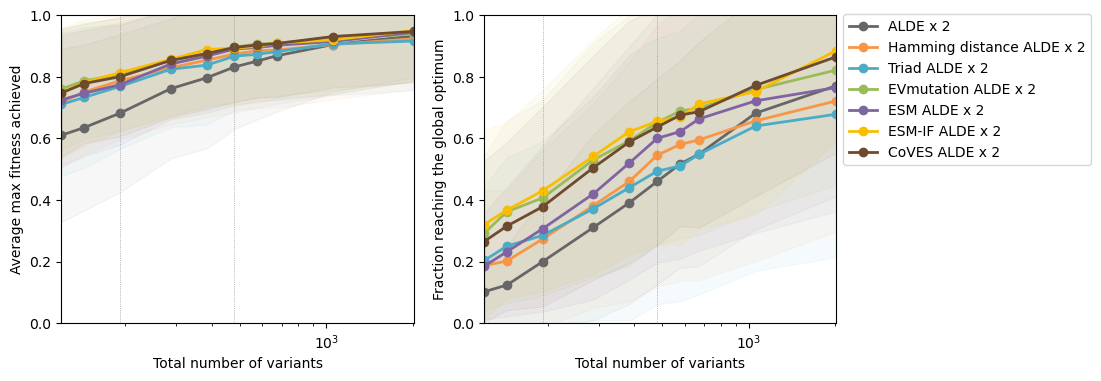

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = [
    "gray",
    "orange",
    "blue",
    "green",
    "purple",
    "yellow",
    "brown",
    # "light_brown",
    # "maroon",
]
ls = ["solid"] * 7 # + ["dashed"] * 2

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes_mean", "if_truemaxs_mean"],
    ["mean_all", "fraction_max"],
    ["Average max fitness achieved", "Fraction reaching the global optimum"],
):

    for i, mlde_opts in enumerate(
        [
            "ALDE x 2",
            "Hamming distance ALDE x 2",
            "Triad ALDE x 2",
            "EVmutation ALDE x 2",
            "ESM ALDE x 2",
            "ESM-IF ALDE x 2",
            "CoVES ALDE x 2",
            # "EVmutation + Hamming distance",
            # "ESM-IF + Hamming distance",
        ]
    ):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            # mlde_df["n_sample"],
            TOTAL_N_LIST,
            mlde_df[f"{mlde_metric}"],
            label=mlde_opts, # .replace("ftALDE: ", ""),
            marker="o",
            linestyle=ls[i],
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            # mlde_df["n_sample"],
            TOTAL_N_LIST,
            mlde_df[mlde_metric] - mlde_df[mlde_metric.replace("mean", "std")],
            mlde_df[mlde_metric] + mlde_df[mlde_metric.replace("mean", "std")],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )

    ax.axvline(96+96, linestyle="dotted", color="gray", linewidth=0.5)
    ax.axvline(384+96, linestyle="dotted", color="gray", linewidth=0.5)

    ax.set_xlim(TOTAL_N_LIST[0], TOTAL_N_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Total number of variants")
    ax.set_ylabel(y_label)

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1.025))

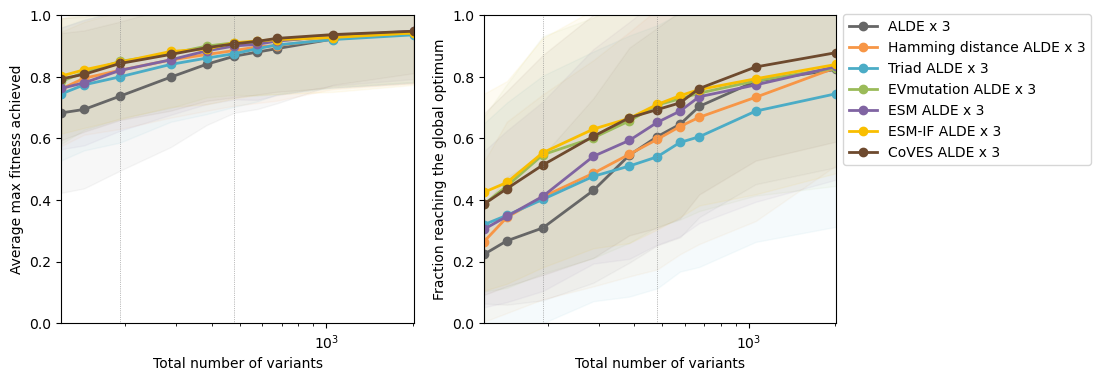

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = [
    "gray",
    "orange",
    "blue",
    "green",
    "purple",
    "yellow",
    "brown",
    # "light_brown",
    # "maroon",
]
ls = ["solid"] * 7 # + ["dashed"] * 2

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes_mean", "if_truemaxs_mean"],
    ["mean_all", "fraction_max"],
    ["Average max fitness achieved", "Fraction reaching the global optimum"],
):

    for i, mlde_opts in enumerate(
        [
            "ALDE x 3",
            "Hamming distance ALDE x 3",
            "Triad ALDE x 3",
            "EVmutation ALDE x 3",
            "ESM ALDE x 3",
            "ESM-IF ALDE x 3",
            "CoVES ALDE x 3",
            # "EVmutation + Hamming distance",
            # "ESM-IF + Hamming distance",
        ]
    ):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            # mlde_df["n_sample"],
            TOTAL_N_LIST,
            mlde_df[f"{mlde_metric}"],
            label=mlde_opts, # .replace("ftALDE: ", ""),
            marker="o",
            linestyle=ls[i],
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            # mlde_df["n_sample"],
            TOTAL_N_LIST,
            mlde_df[mlde_metric] - mlde_df[mlde_metric.replace("mean", "std")],
            mlde_df[mlde_metric] + mlde_df[mlde_metric.replace("mean", "std")],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )

    ax.axvline(96+96, linestyle="dotted", color="gray", linewidth=0.5)
    ax.axvline(384+96, linestyle="dotted", color="gray", linewidth=0.5)

    ax.set_xlim(TOTAL_N_LIST[0], TOTAL_N_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Total number of variants")
    ax.set_ylabel(y_label)

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1.025))

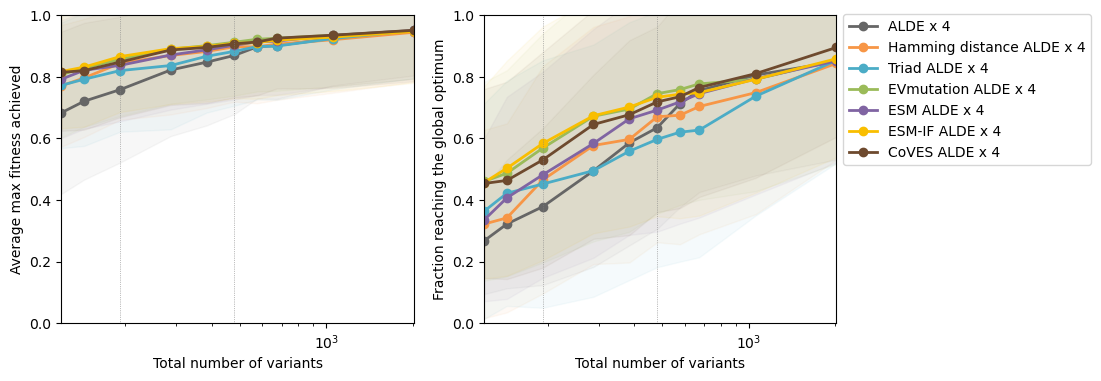

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
mlde_color_list = [
    "gray",
    "orange",
    "blue",
    "green",
    "purple",
    "yellow",
    "brown",
    # "light_brown",
    # "maroon",
]
ls = ["solid"] * 7 # + ["dashed"] * 2

for ax, mlde_metric, de_metric, y_label in zip(
    axes,
    ["top_maxes_mean", "if_truemaxs_mean"],
    ["mean_all", "fraction_max"],
    ["Average max fitness achieved", "Fraction reaching the global optimum"],
):

    for i, mlde_opts in enumerate(
        [
            "ALDE x 4",
            "Hamming distance ALDE x 4",
            "Triad ALDE x 4",
            "EVmutation ALDE x 4",
            "ESM ALDE x 4",
            "ESM-IF ALDE x 4",
            "CoVES ALDE x 4",
            # "EVmutation + Hamming distance",
            # "ESM-IF + Hamming distance",
        ]
    ):

        mlde_df = avg_mlde_df_dict[mlde_opts]

        ax.plot(
            # mlde_df["n_sample"],
            TOTAL_N_LIST,
            mlde_df[f"{mlde_metric}"],
            label=mlde_opts, # .replace("ftALDE: ", ""),
            marker="o",
            linestyle=ls[i],
            linewidth=2,
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
        )
        ax.fill_between(
            # mlde_df["n_sample"],
            TOTAL_N_LIST,
            mlde_df[mlde_metric] - mlde_df[mlde_metric.replace("mean", "std")],
            mlde_df[mlde_metric] + mlde_df[mlde_metric.replace("mean", "std")],
            color=PRESENTATION_PALETTE_SATURATE[mlde_color_list[i]],
            alpha=0.05,
        )

    ax.axvline(96+96, linestyle="dotted", color="gray", linewidth=0.5)
    ax.axvline(384+96, linestyle="dotted", color="gray", linewidth=0.5)

    ax.set_xlim(TOTAL_N_LIST[0], TOTAL_N_LIST[-1])
    ax.set_ylim(0, 1.0)

    ax.set_xscale("log")
    ax.set_xlabel("Total number of variants")
    ax.set_ylabel(y_label)

    if ax == axes[1]:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1.025))

In [44]:
alde_all = pd.read_csv("results/alde/alde_all.csv")
alde_all

,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,esmif,2,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.945598,0.009332,0.50
1,esmif,2,120,DHFR,onehot,DNN Ensemble,GREEDY,120,0.970425,0.008095,0.62
2,esmif,2,120,DHFR,Random,Random,GREEDY,120,0.898989,0.011104,0.10
3,esmif,2,120,GB1,onehot,Boosting Ensemble,GREEDY,120,0.585663,0.018376,0.00
4,esmif,2,120,GB1,onehot,DNN Ensemble,GREEDY,120,0.660711,0.021403,0.02
...,...,...,...,...,...,...,...,...,...,...,...
24485,NaN,4,2016,TrpB4,onehot,DNN Ensemble,UCB,2016,0.981373,0.007442,0.88
24486,NaN,4,2016,TrpB4,onehot,GP,GREEDY,2016,0.982239,0.005665,0.80
24487,NaN,4,2016,TrpB4,onehot,GP,TS,2016,0.983631,0.005987,0.84
24488,NaN,4,2016,TrpB4,onehot,GP,UCB,2016,0.983598,0.005582,0.82


In [45]:
# Replace NaN values in column 'B' with the string "none"
alde_all['zs'] = alde_all['zs'].fillna("none")
alde_all

,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
0,esmif,2,120,DHFR,onehot,Boosting Ensemble,GREEDY,120,0.945598,0.009332,0.50
1,esmif,2,120,DHFR,onehot,DNN Ensemble,GREEDY,120,0.970425,0.008095,0.62
2,esmif,2,120,DHFR,Random,Random,GREEDY,120,0.898989,0.011104,0.10
3,esmif,2,120,GB1,onehot,Boosting Ensemble,GREEDY,120,0.585663,0.018376,0.00
4,esmif,2,120,GB1,onehot,DNN Ensemble,GREEDY,120,0.660711,0.021403,0.02
...,...,...,...,...,...,...,...,...,...,...,...
24485,none,4,2016,TrpB4,onehot,DNN Ensemble,UCB,2016,0.981373,0.007442,0.88
24486,none,4,2016,TrpB4,onehot,GP,GREEDY,2016,0.982239,0.005665,0.80
24487,none,4,2016,TrpB4,onehot,GP,TS,2016,0.983631,0.005987,0.84
24488,none,4,2016,TrpB4,onehot,GP,UCB,2016,0.983598,0.005582,0.82


In [60]:
slice_df = alde_all[
    (alde_all["rounds"] == 3)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == 384)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()
slice_df

,zs,rounds,n_samples,Protein,Encoding,Model,Acquisition,Timestep,Mean,Std,Frac
5152,esmif,3,384,DHFR,onehot,Boosting Ensemble,GREEDY,384,0.995101,0.002889,0.92
5155,esmif,3,384,GB1,onehot,Boosting Ensemble,GREEDY,384,0.830732,0.019088,0.24
5158,esmif,3,384,ParD2,onehot,Boosting Ensemble,GREEDY,384,1.000000,0.000000,1.00
5161,esmif,3,384,ParD3,onehot,Boosting Ensemble,GREEDY,384,0.999546,0.000318,0.96
5164,esmif,3,384,T7,onehot,Boosting Ensemble,GREEDY,384,0.774220,0.005864,0.02
...,...,...,...,...,...,...,...,...,...,...,...
8812,none,3,384,TrpB3E,onehot,Boosting Ensemble,GREEDY,384,0.552314,0.058531,0.38
8825,none,3,384,TrpB3F,onehot,Boosting Ensemble,GREEDY,384,0.967708,0.022780,0.96
8838,none,3,384,TrpB3G,onehot,Boosting Ensemble,GREEDY,384,0.871218,0.038300,0.78
8864,none,3,384,TrpB3I,onehot,Boosting Ensemble,GREEDY,384,0.992757,0.004090,0.88


In [65]:
list(slice_df["zs"].unique()[1:])

['ed', 'Triad', 'ev', 'esm', 'esmif', 'coves']

In [64]:
list(slice_df["zs"].unique()[1:]) + list(slice_df["zs"].unique())

['ed',
 'Triad',
 'ev',
 'esm',
 'esmif',
 'coves',
 'Random',
 'ed',
 'Triad',
 'ev',
 'esm',
 'esmif',
 'coves']

ed : t=0.085 and p=0.937
Triad : t=1.254 and p=0.242
ev : t=0.810 and p=0.438
esm : t=0.275 and p=0.794
esmif : t=0.851 and p=0.415
coves : t=0.495 and p=0.636
ed : t=-0.397 and p=0.716
Triad : t=-0.062 and p=0.954
ev : t=0.453 and p=0.674
esm : t=-0.118 and p=0.913
esmif : t=0.376 and p=0.725
coves : t=0.405 and p=0.709


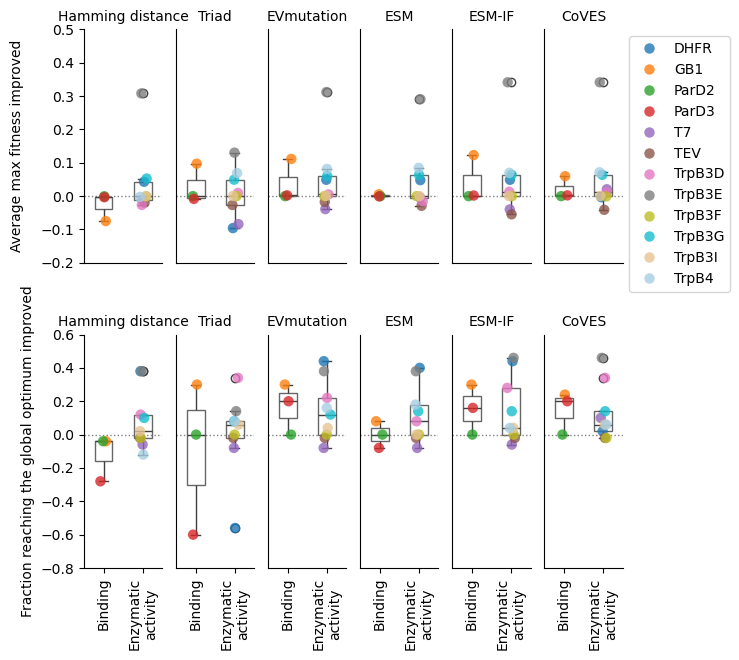

In [91]:
n_round = 3
n_sample = int((384 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 6, figsize=(7.2, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + [o.replace("_score", "") for o in ZS_OPTS], ordered=True)
slice_df = slice_df.sort_values(by=['zs', "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {'Mean': "Average max fitness improved", "Frac": "Fraction reaching the global optimum improved"}

for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["Protein", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:])):
        ax = axes[i, z]
        bar_type_df = slice_df[slice_df["zs"] == zs][["Protein", "type", x]].reset_index(drop=True).copy()
        
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df['Protein'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.5
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.2, ymax)
        else:
            ymax = 0.6
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks


        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(ZS_OPTS_LEGEND[zs+"_score"],fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,5].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)

ed : t=0.379 and p=0.730
Triad : t=1.121 and p=0.313
ev : t=0.710 and p=0.513
esm : t=0.504 and p=0.646
esmif : t=0.710 and p=0.514
coves : t=0.413 and p=0.704
ed : t=0.016 and p=0.989
Triad : t=-0.007 and p=0.995
ev : t=0.516 and p=0.642
esm : t=0.182 and p=0.868
esmif : t=0.604 and p=0.593
coves : t=0.088 and p=0.936


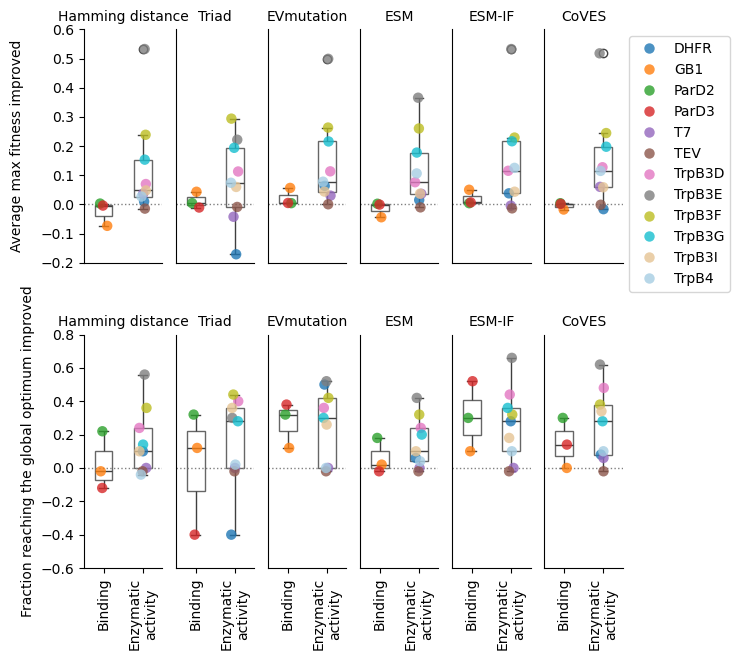

In [93]:
n_round = 3
n_sample = int((96 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 6, figsize=(7.2, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + [o.replace("_score", "") for o in ZS_OPTS], ordered=True)
slice_df = slice_df.sort_values(by=['zs', "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {'Mean': "Average max fitness improved", "Frac": "Fraction reaching the global optimum improved"}

for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["Protein", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:])):
        ax = axes[i, z]
        bar_type_df = slice_df[slice_df["zs"] == zs][["Protein", "type", x]].reset_index(drop=True).copy()
        
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df['Protein'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.6
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.2, ymax)
        else:
            ymax = 0.8
            ax.set_xlabel("")
            ax.set_ylim(-0.6, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks


        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(ZS_OPTS_LEGEND[zs+"_score"],fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,5].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)

ed : t=0.295 and p=0.786
Triad : t=1.012 and p=0.359
ev : t=0.655 and p=0.544
esm : t=0.379 and p=0.729
esmif : t=0.847 and p=0.431
coves : t=0.640 and p=0.557
ed : t=-0.203 and p=0.852
Triad : t=-0.050 and p=0.963
ev : t=0.431 and p=0.696
esm : t=0.120 and p=0.913
esmif : t=0.716 and p=0.522
coves : t=0.312 and p=0.776


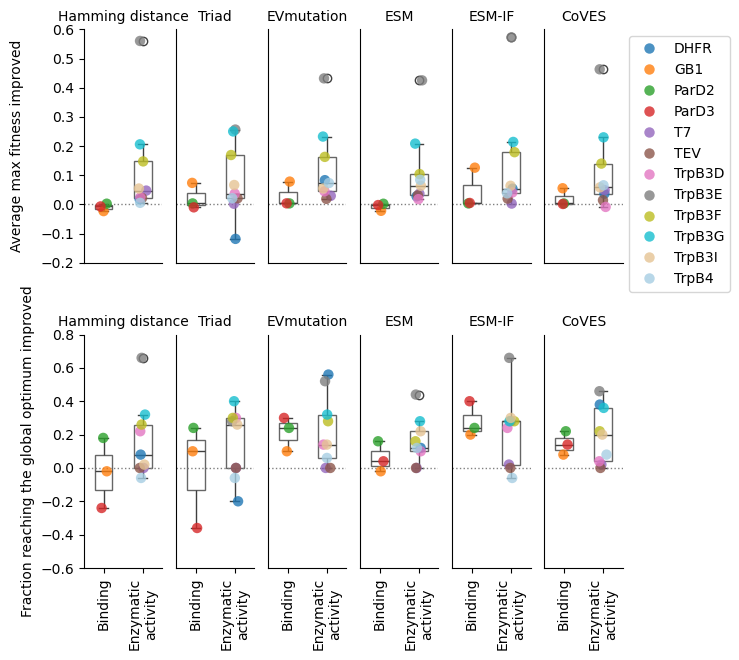

In [94]:
n_round = 4
n_sample = int((96 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 6, figsize=(7.2, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + [o.replace("_score", "") for o in ZS_OPTS], ordered=True)
slice_df = slice_df.sort_values(by=['zs', "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {'Mean': "Average max fitness improved", "Frac": "Fraction reaching the global optimum improved"}

for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["Protein", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:])):
        ax = axes[i, z]
        bar_type_df = slice_df[slice_df["zs"] == zs][["Protein", "type", x]].reset_index(drop=True).copy()
        
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df['Protein'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.6
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.2, ymax)
        else:
            ymax = 0.8
            ax.set_xlabel("")
            ax.set_ylim(-0.6, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks


        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(ZS_OPTS_LEGEND[zs+"_score"],fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,5].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)

ed : t=0.074 and p=0.945
Triad : t=1.449 and p=0.178
ev : t=0.805 and p=0.440
esm : t=0.254 and p=0.809
esmif : t=1.007 and p=0.338
coves : t=0.617 and p=0.555
ed : t=-0.222 and p=0.838
Triad : t=0.160 and p=0.880
ev : t=0.344 and p=0.747
esm : t=-0.150 and p=0.890
esmif : t=0.472 and p=0.657
coves : t=0.336 and p=0.756


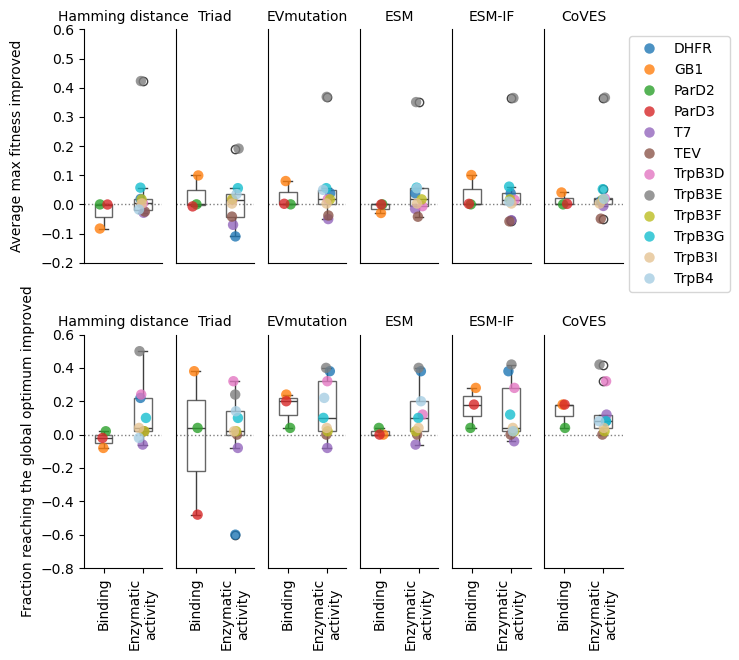

In [96]:
n_round = 4
n_sample = int((384 + 96))

slice_df = alde_all[
    (alde_all["rounds"] == n_round)
    & (alde_all["Encoding"] == "onehot")
    & (alde_all["Model"] == "Boosting Ensemble")
    & (alde_all["Acquisition"] == "GREEDY")
    & (alde_all["n_samples"] == n_sample)
    & (alde_all["Protein"].isin(active_lib_list))
].copy()

fig, axes = plt.subplots(2, 6, figsize=(7.2, 6.4))

# Convert 'Category' column to categorical with defined order
slice_df['zs'] = pd.Categorical(slice_df['zs'], categories=["none"] + [o.replace("_score", "") for o in ZS_OPTS], ordered=True)
slice_df = slice_df.sort_values(by=['zs', "Protein"])

slice_df["zs"] = slice_df["zs"].replace(ZS_OPTS_LEGEND)
slice_df["type"] = slice_df["Protein"].map(lambda x: LIB_INFO_DICT[x]["type"])

ms = ["Mean", "Frac"]
ms_dict = {'Mean': "Average max fitness improved", "Frac": "Fraction reaching the global optimum improved"}

for i in range(len(ms)):
    x = ms[i]
    rand_df = slice_df[slice_df["zs"]=="Random"][["Protein", "type", x]].reset_index(drop=True).copy()

    for z, zs in enumerate(list(slice_df["zs"].unique()[1:])):
        ax = axes[i, z]
        bar_type_df = slice_df[slice_df["zs"] == zs][["Protein", "type", x]].reset_index(drop=True).copy()
        
        # subtract random
        # print(bar_type_df[x])
        merg_df = pd.merge(bar_type_df, rand_df, on=["Protein", "type"], how="outer")
        merg_df["delta"] = merg_df[x+"_x"] - merg_df[x+"_y"]

        sns.boxplot(
            # x="Type", y="Rho", 
            x="type", y="delta", 
            data=merg_df, 
            width=0.45, 
            ax=ax,
            order=["Binding", "Enzymatic activity"],
            # color=PRESENTATION_PALETTE_SATURATE["light_gray"],# palette="pastel", showmeans=True
            boxprops={'facecolor': 'None', 'edgecolor': PRESENTATION_PALETTE_SATURATE["gray"]},
        )
        sns.stripplot(
            # x="Type",
            # y="Rho",
            x="type",
            y="delta",
            data=merg_df,
            order=["Binding", "Enzymatic activity"],
            # order=merg_df['type'].unique()[::-1],
            hue="Protein",
            hue_order=merg_df['Protein'].unique(),
            jitter=True,
            size=7.5,
            # dodge=True,
            palette=sns.color_palette("tab10").as_hex() + ['#e5c494', '#a6cee3'],
            marker="o",
            alpha=0.8,
            ax=ax
        )

        labels = [label.get_text().replace('Enzymatic activity', 'Enzymatic\nactivity') for label in ax.get_xticklabels()]
        
        if i == 0:
            ymax = 0.6
            ax.set_xlabel("")
            ax.set_xticks([])  # Removes x-axis ticks
            ax.set_ylim(-0.2, ymax)
        else:
            ymax = 0.6
            ax.set_xlabel("")
            ax.set_ylim(-0.8, ymax)
            ax.set_xticklabels(labels, rotation=90, ha="center")
            label = ax.yaxis.get_label()
            # Set the new position; (x, y) coordinates in axis units
            label.set_position((0, 0.42))
        
        if z==0:
            ax.set_ylabel(ms_dict[x])
            if i == 0:
                ax.set_ylabel(ms_dict[x], labelpad=12)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])  # Removes y-axis ticks


        # # ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
        ax.legend().remove()
        ax.set_title(ZS_OPTS_LEGEND[zs+"_score"],fontdict={
            'fontsize': 10,
        })
            
        # # Hide the top and right spine
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.axhline(0, color='gray', lw=1, ls="dotted")
        
        # if z != len(ZS_OPTS)-1:
        #     ax.legend().remove()
        # else:
        #     ax.legend(loc="upper left", bbox_to_anchor=(1, 1.0))
        # if z == 0:
        #     ax.set_ylabel(r"Spearman's $\rho$")
        # else:
        #     ax.set_ylabel("")

        t_val, p_value = ttest_ind(
            list(bar_type_df[bar_type_df["type"]=="Binding"][x]),
            list(bar_type_df[bar_type_df["type"]=="Enzymatic activity"][x]),
            equal_var=False,
        )

        print(f"{zs} : t={t_val:.3f} and p={p_value:.3f}")

        # # Draw a line between points
        p = 0.1
        q = 1
        annot_y = ymax
        if p_value < 0.05:
            # ax.plot([p+0.5*(q-p), q-0.5*(q-p)], [annot_y, annot_y], color='gray', lw=1.5)
            ax.text((p+q)*.5, annot_y, "*", ha='center', va='bottom', color='gray')

axes[0,5].legend(loc="upper left", bbox_to_anchor=(1, 1.0))
plt.tight_layout(pad=0, h_pad=1.0, w_pad=1.0)